In [3]:
import numpy as np
import matplotlib.pyplot as plt


In [9]:
# 2 Variant
f_0 = 10 * 10**6  # МГц -> Гц
T = 5 * 10**(-6)  # мкс -> c
q = 4 
A = 1

N = 60

dt = 1 / (f_0 * N)
t = np.arange(0, T, dt)

SNR = 1.0
Nerr = 50
Ntest = 100
SNR = 1.2589254117941673
Nerr = 50
Ntest = 50
SNR = 1.5848931924611136
Nerr = 50
Ntest = 100
SNR = 1.9952623149688795
Nerr = 50
Ntest = 350
SNR = 2.51188643150958
Nerr = 50
Ntest = 300
SNR = 3.1622776601683795
Nerr = 50
Ntest = 150
SNR = 3.9810717055349722
Nerr = 50
Ntest = 350
SNR = 5.011872336272722
Nerr = 50
Ntest = 1150
SNR = 6.309573444801933
Nerr = 50
Ntest = 600
SNR = 7.943282347242816
Nerr = 50
Ntest = 900
SNR = 10.0
Nerr = 50
Ntest = 1750
SNR = 12.589254117941675
Nerr = 50
Ntest = 10750
SNR = 15.848931924611133
Nerr = 50
Ntest = 15600
SNR = 19.952623149688797
Nerr = 50
Ntest = 13650
SNR = 25.118864315095795
Nerr = 50
Ntest = 194750
SNR = 31.622776601683793
Nerr = 50
Ntest = 1622150


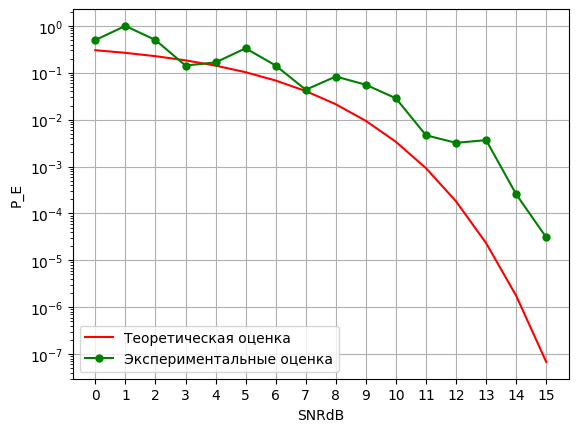

In [2]:
s = np.zeros((q, len(t)))
phi_i_sin = np.zeros((q, len(t)))
phi_i_cos = np.zeros((q, len(t)))
s_i_sin = np.zeros((q, len(t)))
s_i_cos = np.zeros((q, len(t)))

# Расчет сигналов ЧМ
f_i = f_0

for i in range(q):
    f_i = f_0 + (i - 1) / T
    arg = 2 * np.pi * f_i * t
    s[i, :] = A * np.cos(arg)
    phi_i_sin[i, :] = np.sqrt(2 / T) * np.sin(arg)
    phi_i_cos[i, :] = np.sqrt(2 / T) * np.cos(arg)
    s_i_sin[i, :] = A * np.sin(arg)
    s_i_cos[i, :] = A * np.cos(arg)

SNRdB = np.arange(1, 17)  # Отношение сигнал/шум
Pe = np.zeros(len(SNRdB))  # Вероятность ошибки практическая
Pe_t = np.zeros(len(SNRdB))  # Вероятность ошибки теоретическая

Nerrmax = 50  # [20...50...100] % Максимальное число ошибок
E = np.sum(s * s)

for n in range(len(SNRdB)):
    SNR = 10**(SNRdB[n] / 10)  # отношение сигнал/шум
    sigma = np.sqrt(np.sum(E / (2 * SNR)))  # значение дисперсии отсчёта шума
    Nerr = 0  # счётчик числа ошибок
    Ntest = 0  # счётчик числа испытаний

    # Моделирование передатчика и канала
    while Nerr < Nerrmax:
        i = np.random.randint(0, q) 
        theta = 2 * np.pi * np.random.random()  # Случайная фаза
        r = np.cos(theta) * s_i_cos[i, :] + np.sin(theta) * s_i_sin[i, :] + sigma * np.random.randn(len(s[i, :]))  # сигнал на выходе канала 

        # Инициализация матриц r_ci и r_si
        r_ci = np.zeros((q, Nerrmax))
        r_si = np.zeros((q, Nerrmax))
        # Считаем значения для каждого сигнала
        for j in range(q):
            r_ci[j, :] = np.trapz(r * phi_i_cos[j, :], t)  # Значение r_ci
            r_si[j, :] = np.trapz(r * phi_i_sin[j, :], t)  # Значение r_si
        # Формирование ^i по правилу
        i_hat = np.argmax((r_ci[:, :]**2 + r_si[:, :]**2), axis=0)

        # Фиксация результата
        Nerr += np.sum(i_hat != i)  # Увеличение счётчика числа испытаний
        Ntest += len(i_hat)  # Увеличение числа испытаний

    Pe[n] = Nerr / Ntest  # Экспериментальная оценка вероятности ошибки
    SNR = 10**(n / 10)  # Вычисление следующего значения SNR
    N0 = E / SNR

    Pe_t[n] = 1 / 2 * np.exp(-E / (2 * N0))  # Теоретическая оценка вероятности ошибки

    print('SNR =', SNR)
    print('Nerr =', Nerr)
    print('Ntest =', Ntest)

plt.figure()
plt.semilogy(SNRdB - 1, Pe_t, 'r-', label='Теоретическая оценка')
plt.semilogy(SNRdB - 1, Pe, 'g.-', label='Экспериментальные оценка', markersize=10)
plt.legend(loc='lower left')
plt.grid(True)
plt.xlabel('SNRdB')
plt.ylabel('P_E')

plt.xticks(SNRdB - 1, labels=[str(i) for i in range(len(SNRdB))])
plt.show()
